# evauate CAMELS simulations with similar settings to Hongxiang Yan et al 2023
1980-2004 for spin up, and 2005-2014 for evaluation  
Yan et al. median/mean daily KGE is 0.119/-0.495 based on default parameters. 


In [1]:
import os, sys, glob, subprocess, pathlib
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt


# turn off all warnings (not always necessary)
import warnings
warnings.filterwarnings("ignore")

########################################################################################################################
# define functions for calculating metrics

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    ind = np.array([bind.get(itm, np.nan) for itm in a])
    ind1 = np.where(~np.isnan(ind))[0]
    ind2 = ind[ind1]
    return ind1.astype(int), ind2.astype(int) # None can be replaced by any other "not in b" value

def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge

def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.

    Note, all four values KGE, r, α, β are returned, in this order.

    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}

        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.

    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    simulations[simulations<0]=np.nan
    evaluation[evaluation<0]=np.nan
    ind = (~np.isnan(simulations)) & (~np.isnan(evaluation))
    evaluation = evaluation[ind]
    simulations = simulations[ind]
    
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return np.vstack((kge_, r, alpha, beta))


def get_RMSE(obs,sim):
    rmse = np.sqrt(np.nanmean(np.power((sim - obs),2)))
    return rmse

def get_mean_error(obs, sim):
    bias_err = np.nanmean(sim - obs)
    abs_err = np.nanmean(np.absolute(sim - obs))
    return bias_err, abs_err

def get_max_abs_error(d1, d2):
    return np.nanmax(np.abs(d1-d2))

########################################################################################################################
# define functions for reading CTSM outputs

def main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name):
    ########################################################################################################################
    # read files
    ds_simu = xr.open_mfdataset(CTSMfilelist)
    
    # ds_simu['QRUNOFF'] = ds_simu['QOVER'] + ds_simu['QDRAI']
    
    ds_simu = ds_simu[[clm_q_name]]

    if date_start == 'default' or date_end == 'default':
        print(
            'Either date_start or date_end is default. Evaluation period will be the overlapped period of referene data and simulations')
    else:
        ds_simu = ds_simu.sel(time=slice(date_start, date_end))

    ds_simu = ds_simu.load()

    # change time format
    ds_simu['time'] = ds_simu.indexes['time'].to_datetimeindex()

    ########################################################################################################################
    # get the area of a basin to convert the unit of QRUNOFF from mm/s to m3/s

    with xr.open_dataset(fsurdat) as ds_surdat:
        area = ds_surdat.AREA.values

    # calculate streamflow: although mean is used, for Sean's setting, only one basin should be allowed effective in the calibration
    # streamflow? Use mean for this test
    ds_simu[clm_q_name].values = (ds_simu[clm_q_name].values / 1000) * (area * 1e6)  # raw q: mm/s; raw area km2; target: m3/s

    return ds_simu


########################################################################################################################
# define functions for reading CAMELS data

def read_CAMELS_Q(file_Qobs):
    df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)
    years = df_q_in[1].values
    months = df_q_in[2].values
    days = df_q_in[3].values
    dates = [f'{years[i]}-{months[i]:02}-{days[i]:02}' for i in range(len(years))]
    q_obs = df_q_in[4].values * 0.028316847  # cfs to cms
    q_obs[q_obs < 0] = -9999.0
    df_q_out = pd.DataFrame({'Date': dates, 'Runoff_cms': q_obs})
    return df_q_out

def read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name):
    ########################################################################################################################
    # load observation streamflow
    print('Use streamflow reference file:', ref_streamflow)
    df_q_obs = pd.read_csv(ref_streamflow)
    ds_q_obs = xr.Dataset()
    ds_q_obs.coords['time'] = pd.to_datetime(df_q_obs[ref_q_date].values)
    ds_q_obs[ref_q_name] = xr.DataArray(df_q_obs[ref_q_name].values, dims=['time']) # flexible time
    for i in range(10000):
        coli = ref_q_name + str(i)
        if coli in df_q_obs.columns:
            ds_q_obs[coli] = xr.DataArray(df_q_obs[coli].values, dims=['time'])  # flexible time
        else:
            break
    return ds_q_obs


def add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name):
    ########################################################################################################################
    # add upstream flows to simulated streamflow

    add_flow_file = [f for f in add_flow_file.split(',') if len(f)>0]
    if len(add_flow_file) > 0:
        add_flow_file2 = []
        for f in add_flow_file:
            if not os.path.isfile(f):
                print('File does not exist:', f)
                print('Remove it from add flow file list')
            else:
                add_flow_file2.append(f)
        add_flow_file = add_flow_file2

    if len(add_flow_file) > 0:
        print('Flow files will be added to the incremental downstream basin:', add_flow_file)
        q_dd = np.zeros(len(ds_simu.time))
        num = np.zeros(len(ds_simu.time))
        time0 = ds_simu.time.values
        for i in range(len(add_flow_file)):
            df_addi = read_CAMELS_Q(add_flow_file[i])
            # df_addi = pd.read_csv(add_flow_file[i])
            timei = pd.to_datetime(df_addi[ref_q_date].values)
            ind1, ind2 = ismember(np.array(timei), time0)
            q_dd[ind2] = q_dd[ind2] + df_addi[ref_q_name].values[ind1]
            num[ind2] = num[ind2] + 1
        q_dd[num==0] = np.nan

        ds_simu[clm_q_name].values = ds_simu[clm_q_name].values + q_dd
        ratio = np.sum(~np.isnan(ds_simu[clm_q_name].values)) / len(ds_simu[clm_q_name].values)
        if ratio < 0.5:
            print('Warning!!!')
        print(f'The valid ratio of simulated streamflow is {ratio} after add upstream flow')

    return ds_simu



# Yan et al results

median daily kge 0.119
mean daily kge -0.4951120689655173


(array([ 4.,  7.,  5.,  5.,  7.,  4., 12., 12., 20., 22., 61., 48., 55.,
        44., 47., 26., 18.,  3.,  0.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

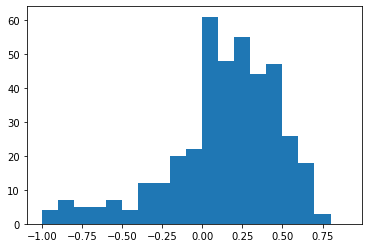

In [2]:
# load Yan's data
df_met_YH = pd.read_csv('/glade/scratch/guoqiang/CLM5_CAMELS_HY/NLDAS2_forcing/Flow_ET_metrics/CLM5_default_parameter_28_metrics.csv')
df_met_YH
print('median daily kge', np.nanmedian(df_met_YH['Daily_KGE']))
print('mean daily kge', np.nanmean(df_met_YH['Daily_KGE']))

plt.hist(df_met_YH['Daily_KGE'], np.arange(-1, 1, 0.1))

Yan metric table daily KGE: [0.069]
Calculated using my functions
kge_, r, alpha, beta
[[0.06925164]
 [0.42561595]
 [1.6942271 ]
 [1.23328998]]


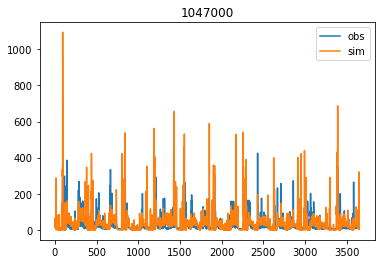

In [3]:
# check one basin
# checkbasin = 1031500
checkbasin = 1047000
print('Yan metric table daily KGE:', df_met_YH.loc[df_met_YH['Basin_ID']==checkbasin]['Daily_KGE'].values)

df_flow_YH = pd.read_csv(f'/glade/scratch/guoqiang/CLM5_CAMELS_HY/NLDAS2_forcing/Flow_series_default_parameter/{checkbasin:08}_daily.csv')
sim = df_flow_YH['sim_flow_m3/s'].values
obs = df_flow_YH[' obs_flow_m3/s'].values
obs = np.array([float(i) for i in obs])

print('Calculated using my functions')
print('kge_, r, alpha, beta')
print(kge(sim, obs))

plt.plot(obs, label='obs')
plt.plot(sim, label='sim')
plt.legend()
plt.title(checkbasin)
plt.show()

# My sim

In [4]:
CTSMfilelist = glob.glob('/glade/scratch/guoqiang/CTSM_outputs/CAMELS_Calib/Distr_Calib_split_nest/CAMELS_test/archive/CAMELS_test_80to14/lnd/hist/*.clm2.h1.*.nc')
CTSMfilelist.sort()
fsurdat = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/shared_data_Sean/surfdata_CAMELS_split_nested_hist_78pfts_CMIP6_simyr2000_c230105.nc'
date_start = '2005-01-01'
date_end = '2014-12-31'

In [5]:
ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/CAMLES_q_split_nest/All_CAMELS_Q_postprocess.csv'

######## default variable names
clm_q_name = 'QRUNOFF'  # default runoff variable name
clm_q_sdim = 'lndgrid'  # spatial dim name
ref_q_name = 'Runoff_cms'
ref_q_date = 'Date'

########################################################################################################################
# load CTSM streamflow (m3/s)
ds_simu = main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name)
ds_simu = ds_simu.transpose('time', clm_q_sdim)

########################################################################################################################
# load CAMELS observation streamflow (m3/s)
df_q_obs = pd.read_csv(ref_streamflow)
ds_q_obs = xr.Dataset()
ds_q_obs.coords['time'] = pd.to_datetime(df_q_obs[ref_q_date].values)
ds_q_obs[ref_q_name] = xr.DataArray(df_q_obs.values[:, 1:], dims=['time', clm_q_sdim]) # flexible time

########################################################################################################################
# evaluation

ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

d1 = ds_q_obs[ref_q_name].values
d2 = ds_simu[clm_q_name].values
d1[d1 < 0] = np.nan
d2[d2 < 0] = np.nan
ds_q_obs[ref_q_name].values = d1
ds_simu[clm_q_name].values = d2

kge_q_all = []
kge_q_all_com = np.zeros([d1.shape[1], 4])
for i in range(d1.shape[1]):
    # kge_q = get_modified_KGE(obs=d1[:,i].astype(np.float64), sim=d2[:,i])
    kge_q = kge(d2[:,i], d1[:,i].astype(np.float64))
    kge_q_all.append(kge_q[0])
    kge_q_all_com[i] = np.squeeze(kge_q)
    
kge_q_median = np.nanmedian(kge_q_all)
kge_q_mean = np.nanmean(kge_q_all)
print(f'Evaluation result: kge_q_median={kge_q_median}')
print(f'Evaluation result: kge_q_mean={kge_q_mean}')

# d1 = ds_q_obs[ref_q_name].groupby('time.month').mean().values
# d2 = ds_simu[clm_q_name].groupby('time.month').mean().values
# maxabserror_q_all = []
# for i in range(d1.shape[1]):
#     maxabserror_q = get_max_abs_error(d1[:, i].astype(np.float64), d2[:, i])
#     maxabserror_q_all.append(maxabserror_q)

# maxabserror_q_median = np.nanmedian(maxabserror_q_all)
# print(f'Evaluation result: kge_q_median={kge_q_median}, maxabserror_q_median={maxabserror_q_median}')

########################################################################################################################
# write objective functions to file.
# metrics will be minimized during optimization
# dfout = pd.DataFrame([[1 - kge_q_median, maxabserror_q_median]], columns=['metric1', 'metric2'])

Evaluation result: kge_q_median=-0.6629103381414541
Evaluation result: kge_q_mean=-13.580480343914692


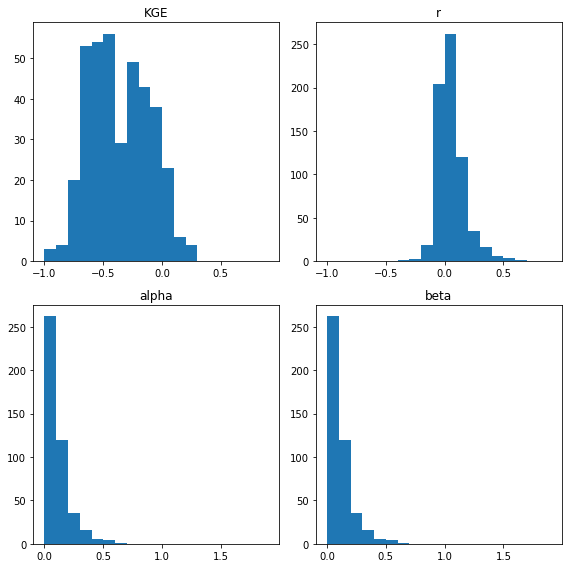

In [6]:
fig, axs = plt.subplots(2, 2, figsize=[8, 8])

ax = axs[0, 0]
ax.hist(kge_q_all_com[:,0], np.arange(-1, 1, 0.1))
ax.set_title('KGE')

ax = axs[0, 1]
ax.hist(kge_q_all_com[:,1], np.arange(-1, 1, 0.1))
ax.set_title('r')

ax = axs[1, 0]
ax.hist(kge_q_all_com[:,1], np.arange(0, 2, 0.1))
ax.set_title('alpha')

ax = axs[1, 1]
ax.hist(kge_q_all_com[:,1], np.arange(0, 2, 0.1))
ax.set_title('beta')

plt.tight_layout()
plt.show()

In [7]:
kge_q_median = np.nanmedian(kge_q_all)
kge_q_mean = np.nanmean(kge_q_all)
print(f'Evaluation result: kge_q_median={kge_q_median}')
print(f'Evaluation result: kge_q_mean={kge_q_mean}')

Evaluation result: kge_q_median=-0.6629103381414541
Evaluation result: kge_q_mean=-13.580480343914692


In [10]:
# results for the checked basin
index = np.where(df_q_obs.columns[1:] == str(checkbasin))[0][0]
print('kge:', kge_q_all[index])
print('kge all:', kge_q_all_com[index])

kge: [-0.64782091]
kge all: [-0.64782091  0.04265418  0.05746119  0.04583894]


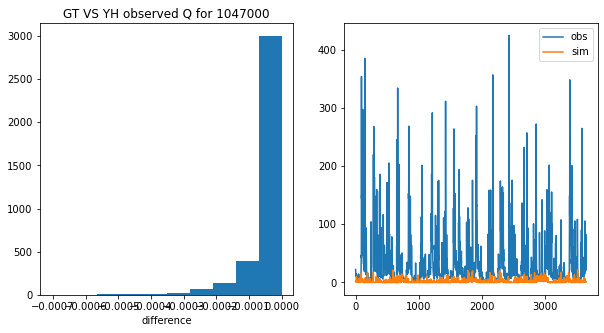

In [9]:
# compare to my own observed streamflow to make sure they are the same

file = f'/glade/p/ral/hap/common_data/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all/{checkbasin:08}_streamflow_qc.txt'
df_raw = pd.read_csv(file, delim_whitespace=True, header=None)
df_raw[4] = df_raw[4]*0.0283168
df_raw = df_raw.loc[df_raw[1]>=2005]


ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/CAMLES_q_split_nest/All_CAMELS_Q_postprocess.csv'
df_q_obs = pd.read_csv(ref_streamflow)

v1 = df_flow_YH[' obs_flow_m3/s'].values
v1 = np.array([float(i) for i in v1])

ind = (df_raw[2].values==2) & (df_raw[3].values==29)
v2 = df_raw.loc[df_raw[1]>=2005][4].values
v3 = df_q_obs.loc[df_q_obs['Date']>='2005-01-01'][str(checkbasin)].values
v2 = v2[~ind]
v3 = v3[~ind]
v2[v2<0]=np.nan
v3[v3<0]=np.nan

fig, axs = plt.subplots(1, 2, figsize=[10, 5])

axi = axs[0]
axi.hist(v1-v3)
axi.set_title(f'GT VS YH observed Q for {checkbasin}')
axi.set_xlabel('difference')

d2 = ds_simu[clm_q_name].values
d1[d1 < 0] = np.nan
d2[d2 < 0] = np.nan



# plot simu
ind = np.where(df_q_obs.columns[1:]==str(checkbasin))[0][0]
v4 = ds_simu[clm_q_name].values[:, ind]

axi = axs[1]
axi.plot(v3, label='obs')
axi.plot(v4, label='sim')
plt.legend()

plt.show()

# CTSM streamflow variables

In [11]:
# load CTSM streamflow (m3/s)
ds_simu_all = xr.open_mfdataset(CTSMfilelist)

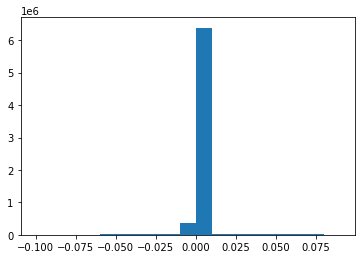

In [28]:
d1 = ds_simu_all.QRUNOFF.values
d2 = ds_simu_all.QOVER.values
d3 = ds_simu_all.QDRAI.values
bias = ( d1 - (d2+d3) ) / d1
bias[d1==0]=np.nan

plt.hist(ratio[~np.isnan(ratio)], np.arange(-0.1, 0.1, 0.01))
plt.show()